# Topology lab, part 2

## Network - preliminary analysis

We will now build 4 different networks to analyse further:
- A full association network filtered using FDR-corrected P values (<0.01). This is an unweighted network.
- The subset of positively associated features, where correlation coefficient is used as weight.
- kNN-G that we will generate from the expression profile. This will be unweighted.
- A random network based on the [Erdos-Renyi model](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model), with the same node and edge number of each network. 

This will be a null-model for our analyses. The idea is that if a certain property found in one of our graphs is  reproduced in a random graph, then we do not need to account for any other possible explanations for that feature. In other words, if a property of a graph (e.g. clustering) is not found in a random network, we can assume that it does not appear in our biological network due to randomness.

For running the lab please first select the kernel `igraph` in the upper right corner of the notebook.


In [8]:
import igraph as ig
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
n_nodes = 2102
PRmatrix = pd.read_csv('/home/jovyan/lab/data/serialization/PRmatrix.tsv', sep="\t", index_col=False)
fdr_pos_mat = pd.read_csv('/home/jovyan/lab/data/serialization/fdr_pos_mat.tsv', sep="\t", index_col=False)
knnG = pd.read_csv('/home/jovyan/lab/data/serialization/knnG.tsv', sep="\t", index_col=False)

### Generates each of the graphs
#positive associations, weighted
pos_w=ig.Graph.TupleList([tuple(x) for x in fdr_pos_mat.values], directed=False, edge_attrs=['w'])

#full network, unweighted
edge_list=PRmatrix.copy().loc[PRmatrix.isin(pd.unique(fdr_pos_mat[['feat1','feat2']].values.flatten())).sum(1)==2,['feat1','feat2']].values
all_u=ig.Graph.TupleList([tuple(x) for x in edge_list], directed=False)

#knnG, unweighted
knn=ig.Graph.TupleList([tuple(x) for x in knnG.values], directed=False)

#random network, unweighted, node and edge number based on a network of the same size
random_posw=ig.Graph.Erdos_Renyi(n=n_nodes, m=len(fdr_pos_mat.values), directed=False, loops=False)
random_allu=ig.Graph.Erdos_Renyi(n=n_nodes, m=len(edge_list), directed=False, loops=False)
random_knn=ig.Graph.Erdos_Renyi(n=n_nodes, m=len(knnG.values), directed=False, loops=False)

For representation purposes we will see how a short knn graph looks - be careful in drawing the others, as they have many more edges it becomes computationally heavy.

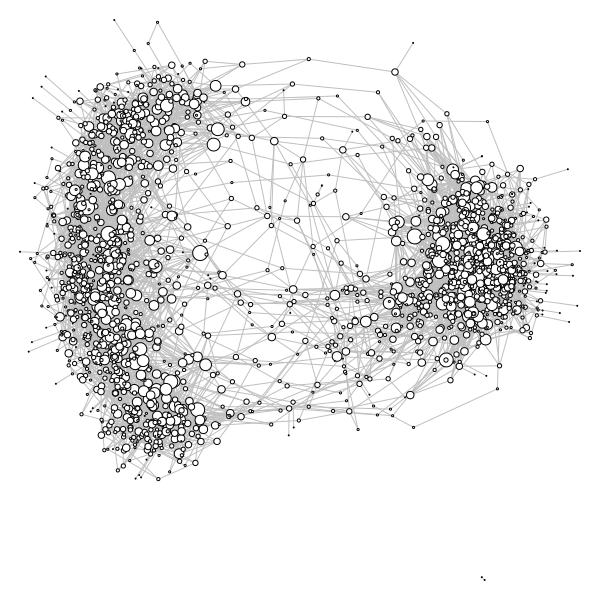

In [5]:
import random
import numpy as np

#random subset of knn graph for plotting
short_knn=ig.Graph.TupleList([tuple(x) for x in knnG.values[random.sample(list(np.arange(len(knnG.values))), 5000)]], directed=False)

#This plots each graph, using degree to present node size:
short_knn.vs['degree']=short_knn.degree() 
short_knn.vs['degree_size']=[(x*15)/(max(short_knn.vs['degree'])) for x in short_knn.vs['degree']] #degree is multiplied by 10 so that we can see all nodes

layout = short_knn.layout_mds()
ig.plot(short_knn, layout=layout, vertex_color='white', edge_color='silver', vertex_size=short_knn.vs['degree_size'])

In the next table, we can see that while the same number of nodes is found in all networks, the number of edges varies greatly. We also see that the network is fully connected, which is not allways the case. If it wasn't connected, we could select the ***k***  largest connected components, and proceed the analyses with them. The largest connected component is called the *giant component*.

In [6]:
#function to get graph properties, takes a few minutes to run
def graph_prop(input_graph):
    ncount=nn.vcount()
    ecount=nn.ecount()
    diameter=nn.diameter()
    av_path=nn.average_path_length()
    dens=nn.density()
    clustering=nn.transitivity_undirected() #this is the global clustering coefficient
    conn=nn.is_connected()
    min_cut=nn.mincut_value()
    out=pd.DataFrame([ncount, ecount, diameter, av_path, dens, clustering, conn, min_cut],
                 index=['node_count','edge_count','diameter','av_path_length','density','clustering_coef','connected?','minimum_cut']).T
    return(out)

#summarizing graph properties
network_stats=pd.DataFrame()
for nn in [pos_w, all_u, knn, random_posw, random_allu, random_knn]:
    network_stats=pd.concat([network_stats,graph_prop(nn)])
    
network_stats.index=['pos_w','all_u','knn','pos_w_random', 'all_u_random', 'knn_random']
network_stats

IOStream.flush timed out


node_count edge_count diameter av_path_length   density  \
pos_w              2102     293544        8       2.933039  0.132937   
all_u              2102     402360        7        2.11979  0.182216   
knn                2102     420400        4       2.320016  0.190386   
pos_w_random       2102     293544        2       1.867063  0.132937   
all_u_random       2102     402360        2       1.817784  0.182216   
knn_random         2102     420400        2       1.809614  0.190386   

             clustering_coef connected? minimum_cut  
pos_w                0.71453      False         0.0  
all_u               0.610098      False         0.0  
knn                 0.590294       True       203.0  
pos_w_random        0.132909       True       218.0  
all_u_random         0.18214       True       324.0  
knn_random          0.190351       True       345.0

### Questions:
- Why is the diameter and average path length lower in the case of the full network and the random network, compared to the other two networks? What about the other random networks?
- Why do you think the clustering coefficient is lower for the knn compared with the other networks?
- Why is the minimum cut much larger in the random network compared to the others?
- How do you think the selected *k* would influence the properties above for kNNG?

# Centrality analysis

We'll look into different centrality measures:
- [Degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)) - number of neighbors of a node
- [Betweenness](https://en.wikipedia.org/wiki/Betweenness_centrality) - measures how many shortest paths in the network pass through a node.
- [Closeness](https://en.wikipedia.org/wiki/Centrality#Closeness_centrality) - the average length of the shortest paths between a node and all other nodes 
- [Eccentricity](https://en.wikipedia.org/wiki/Distance_(graph_theory)) - largest shortest path from a node to any other node. Nodes with high eccentricity tend to be on the periphery.
- [Eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) - a node is more central if its neighbors show a high degree.

Degree, Betweenness, Closeness and Eigenvector centralities may be additionally computed for the positive association network by taking into account each edge's weight. For instance, for degree this is done for each node by summing each edge's degree.

Because the number of shortest paths in a network scales with the network size, we normalize Eccentricity and Betweenness with respect to the network size so that they can be compared between the four networks above.

Note that many [other centrality metrics](https://en.wikipedia.org/wiki/Centrality) can be computed. For instance, [PageRank](https://en.wikipedia.org/wiki/PageRank) and [HITS](https://en.wikipedia.org/wiki/HITS_algorithm) take into account edge directionality to compute what are the most central nodes in a network. 

**Degree distribution**  
Let's start by comparing the degrees of the random network against the three other networks. From the figures below it seems that there is no relationship between the degree of the random network, and any of the three others.

In [7]:
# TODO: to/from json
degree_data =  {
        'nodes': list(range(n_nodes)),
        'degree_pos_w': pos_w.degree(),
        'degree_all_u': all_u.degree(),
        'degree_knn': knn.degree(),
        'degree_random_posw': random_posw.degree(),
        'degree_random_allu': random_allu.degree(),
        'degree_random_knn': random_knn.degree(),
    }

**Centrality**  
We will now compare different centrality metrics between the graphs.

In [9]:
import numpy as np

graphs = {"pos_w": pos_w, "all_u": all_u, "knn": knn, "random_posw": random_posw, "random_allu": random_allu, "random_knn": random_knn}
centralities_list=['degree (larger ~ central)','eccentricity (smaller ~ central)','betweenness (larger ~ central)', 'closeness (larger ~ central)','eigenvector (larger ~ central)']

def compute_all_centralities(graph, graph_name):
    """Computes centrality metrics for a graph.
    """
    deg = graph.degree(loops=False)
    node_n = graph.vcount()
    # scaled to account for network size
    ecc = [(2*x / ((node_n-1)*(node_n-2))) for x in graph.eccentricity()]
    btw = [(2*x / ((node_n-1)*(node_n-2))) for x in graph.betweenness(directed=False)] 
    eig = graph.eigenvector_centrality(directed=False, scale=False)
    # For disconnected graphs, computes closeness from the largest connected component
    if(graph.is_connected()):
        cls = graph.closeness(normalized=True)
    else:
        cls = graph.clusters(mode='WEAK').giant().closeness(normalized=True)
    
    df = pd.DataFrame([deg, ecc, btw, cls, eig], index = centralities_list).T
    df['graph'] = graph_name
    df = df.loc[:, np.append(['graph'], 
                             df.columns[df.columns!='graph'])] # reorder columns
    return df
    

network_centralities_raw=pd.DataFrame()
for index, (graph_name, graph) in enumerate(graphs.items()):
    df = compute_all_centralities(graph, graph_name)
    ##Adds centralities for each node in the network
    graph.vs['degree'] = df['degree (larger ~ central)']
    graph.vs['eccentricity'] = df['eccentricity (smaller ~ central)']
    graph.vs['betweenness'] = df['betweenness (larger ~ central)']
    graph.vs['closeness'] = df['closeness (larger ~ central)']
    graph.vs['eigenvector'] = df['eigenvector (larger ~ central)']
    network_centralities_raw = pd.concat([network_centralities_raw, df])

In [10]:
network_centralities_raw.head()

graph  degree (larger ~ central)  eccentricity (smaller ~ central)  \
0  pos_w                        2.0                      4.532989e-07   
1  pos_w                        1.0                      9.065978e-07   
2  pos_w                        1.0                      9.065978e-07   
3  pos_w                        4.0                      2.719793e-06   
4  pos_w                       19.0                      2.266494e-06   

   betweenness (larger ~ central)  closeness (larger ~ central)  \
0                    4.532989e-07                      0.259888   
1                    0.000000e+00                      0.282556   
2                    0.000000e+00                      0.325719   
3                    0.000000e+00                      0.296716   
4                    2.620360e-04                      0.294630   

   eigenvector (larger ~ central)  
0                    0.000000e+00  
1                    0.000000e+00  
2                    0.000000e+00  
3                    6.649338e-09  
4                    1.892555e-07

In [11]:
network_centralities_raw.to_csv("/home/jovyan/lab/data/serialization/network_centralities_raw.csv", sep = "\t", index = False)

In [12]:
n_nodes * 6

12612

Let's now compute centrality ranks so that we can compare them within and between networks

In [13]:
full_centralities=pd.DataFrame()
for net in [0,1,2]:
    net_in=[pos_w, all_u, knn][net]
    net_nm=['pos_w', 'all_u', 'knn'][net]
    temp=pd.DataFrame([net_in.vs[att] for att in ['name','degree','betweenness', 'closeness','eccentricity','eigenvector']], index=['name','degree','betweenness', 'closeness','eccentricity','eigenvector']).T
    temp.columns=[x+'|'+net_nm for x in temp.columns]
    temp.rename(columns={'name|'+net_nm:'name'}, inplace=True)
    
    ## For all but eccentricity centrality, we compute the rank in ascending mode
    ## so that higher ranking means more central. we need to reverse this for eccentricity
    temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')]=temp.loc[:,temp.columns.str.contains('deg|bet|clos|eig')].rank(pct=True, ascending=True)
    temp.loc[:,temp.columns.str.contains('eccentricity')]=temp.loc[:,temp.columns.str.contains('eccentricity')].rank(pct=True, ascending=False
                                                              )
    temp['median_centrality|'+net_nm]=temp.loc[:,temp.columns!='name'].median(1)
    if(net==0):
        full_centralities=temp
    else:
        full_centralities=pd.merge(full_centralities, temp, on='name')
full_centralities.set_index('name', inplace=True)
#full_centralities=pd.merge(full_centralities, data[['Type']], left_index=True, right_index=True, how='left')
full_centralities['median|ALL']=full_centralities.loc[:,full_centralities.columns.str.contains('median')].median(1)


### Correlations are computed between ranks, after inverting the rank for eccentricity
def correlations_centralities(graph_name):
    """
    Returns squared correlation matrix.
    """
    temp_corr=full_centralities.copy().loc[:,full_centralities.columns!='Type'].dropna().astype('float')
    temp_corr=temp_corr.loc[:,temp_corr.columns.str.contains(graph_name)]
    temp_corr.columns=temp_corr.columns.str.replace('\|.+','')
    temp_corr=temp_corr.corr(method='spearman')
    np.fill_diagonal(temp_corr.values, np.nan)
    return(temp_corr)

all_u_centcorr=correlations_centralities('all_u')
knn_centcorr=correlations_centralities('knn')
pos_w_centcorr=correlations_centralities('pos_w')

In [14]:
all_u_centcorr

degree|all_u  betweenness|all_u  closeness|all_u  \
degree|all_u                      NaN           0.566437         0.660516   
betweenness|all_u            0.566437                NaN         0.332536   
closeness|all_u              0.660516           0.332536              NaN   
eccentricity|all_u           0.361403           0.355912         0.221382   
eigenvector|all_u            0.949016           0.507816         0.726121   
median_centrality|all_u      0.945971           0.627798         0.763778   

                         eccentricity|all_u  eigenvector|all_u  \
degree|all_u                       0.361403           0.949016   
betweenness|all_u                  0.355912           0.507816   
closeness|all_u                    0.221382           0.726121   
eccentricity|all_u                      NaN           0.360812   
eigenvector|all_u                  0.360812                NaN   
median_centrality|all_u            0.440496           0.950041   

                         median_centrality|all_u  
degree|all_u                            0.945971  
betweenness|all_u                       0.627798  
closeness|all_u                         0.763778  
eccentricity|all_u                      0.440496  
eigenvector|all_u                       0.950041  
median_centrality|all_u                      NaN

In [16]:
all_u_centcorr.to_csv("/home/jovyan/lab/data/serialization/all_u_centcorr.csv", sep = "\t", index = True)
knn_centcorr.to_csv("/home/jovyan/lab/data/serialization/knn_centcorr.csv", sep = "\t", index = True)
pos_w_centcorr.to_csv("/home/jovyan/lab/data/serialization/pos_w_centcorr.csv", sep = "\t", index = True)

In [17]:
full_centralities.columns.values

array(['degree|pos_w', 'betweenness|pos_w', 'closeness|pos_w',
       'eccentricity|pos_w', 'eigenvector|pos_w',
       'median_centrality|pos_w', 'degree|all_u', 'betweenness|all_u',
       'closeness|all_u', 'eccentricity|all_u', 'eigenvector|all_u',
       'median_centrality|all_u', 'degree|knn', 'betweenness|knn',
       'closeness|knn', 'eccentricity|knn', 'eigenvector|knn',
       'median_centrality|knn', 'median|ALL'], dtype=object)

__Visualize central nodes in graph plots__

In [18]:
knn_centralities=full_centralities.loc[:,full_centralities.columns.str.contains('knn')]
knn_centralities=knn_centralities.loc[:,knn_centralities.columns!='median_centrality|knn']
knn_centralities.columns=knn_centralities.columns.str.replace('\\|.+','')

##top nodes based on eccentricity
knn_top_ecc=knn_centralities['eccentricity|knn'].sort_values(ascending=False).index.values[:1]

##top nodes based on degree
knn_top_deg=knn_centralities['degree|knn'].sort_values(ascending=False).index.values[:1]

##random nodes to help visualize
##warning, do not increase this value much higher than 500, or you may have problems rendering this image
knn_others=knn_centralities.sample(500).index.values

## full list
node_list=np.append(np.append(knn_top_deg, knn_top_ecc), knn_others)

## subsets nodes
knn_to_draw=knn.subgraph(knn.vs.select([x.index for x in knn.vs if x['name'] in node_list]))
knn_to_draw.vs['color']=['red' if x['name']  in knn_top_deg else 'green' if x['name'] in knn_top_ecc else 'white' for x in knn_to_draw.vs]

layout = knn_to_draw.layout_auto()
ig.plot(knn_to_draw, layout=layout, vertex_color=knn_to_draw.vs['color'], edge_color='silver', vertex_size=7)

__Plots and questions__

You can revert now or later to part 1 for plots and questions!

# Community analysis

Node communities may be identified based on different metrics including [Modularity](https://en.wikipedia.org/wiki/Modularity_(networks)) or [Density](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114). We will look at community detection through modularity.

## Modularity of a small graph

Recall that the Modularity of a community is given by $$Q = \frac{1}{2m} \sum_{c}(e_c - \frac{K_c^2}{2m})$$

where $e_c$ is the number of edges in community $c$, and $\frac{K_c^2}{2m}$ is the expected number of edges in the community given the $K_c$ sum of degrees of its nodes, for a network with $m$ edges. This will correspond to

$$Q = \frac{1}{2m} \sum_{ij}[A_{ij} - \frac{k_i k_j}{2m}\delta(c_i,c_j)]$$

where $A_ij$ is the Adjacency between nodes $i$ and $j$, $k_i$ and $k_j$ are their degree, and $\delta(c_i,c_j)$ is the [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta), defined as 1 if nodes $i$ and $j$ are in the same community, or 0 if they are not. Let's examine the following small network, with communities given by the two colors: red `[A,B,C,D,H]` and blue `[E,F,G]`.

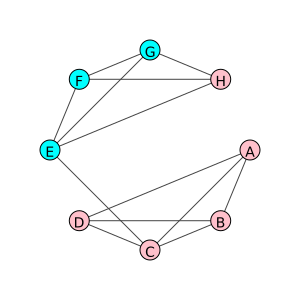

In [19]:
g = ig.Graph([(0,1), (0,2), (1,2), (0,3), (2,3), (1,3), (2,4), (4,5), (5,6), (4,6), (4,7), (5,7), (6,7)])

g.vs["name"] = ["A", "B", "C", "D", "E", "F", "G","H"]
g.vs["module"] = ["f", "f", "f", "f", "m", "m","m", "f"]


layout = g.layout_circle()
g.vs["label"] = g.vs["name"]
color_dict = {"m": "cyan", "f": "pink"}
g.vs["color"] = [color_dict[module] for module in g.vs["module"]]
ig.plot(g, layout = layout, bbox = (300, 300), margin = 50)

For this network, we have the following adjacency matrix.

In [20]:
pd.DataFrame( g.get_adjacency(), index=g.vs["name"],  columns=g.vs["name"] )

A  B  C  D  E  F  G  H
A  0  1  1  1  0  0  0  0
B  1  0  1  1  0  0  0  0
C  1  1  0  1  1  0  0  0
D  1  1  1  0  0  0  0  0
E  0  0  1  0  0  1  1  1
F  0  0  0  0  1  0  1  1
G  0  0  0  0  1  1  0  1
H  0  0  0  0  1  1  1  0

We will compute the modularity of this network given the 2 communities above, herein identified as communities `1` and `2`.

In [21]:
def modularity(graph, membership):
    """
    Computes the modularity of `graph` for a given module `membership`.
    """
    m=len(graph.es.indices) #edge number
    A=pd.DataFrame(graph.get_adjacency()) #adjacency matrix
    Q=[] 
    for i in A.index:
        for j in A.columns:
            if(membership[i]==membership[j]):
                deltaij=1
            else:
                deltaij=0
            Q=np.append(Q, (A.loc[i,j]-(g.vs[i].degree()*g.vs[j].degree())/(2*m))*deltaij)
    Q=(1/(2*m))*np.sum(Q)
    out=Q
    return(out)

modularity(g, [1,1,1,1,2,2,2,1])

0.16568047337278102

As this is a very small network, we can take a brute-force approach and examine all possible membership combinations that will yield the highest possible modularity.

In [22]:
import itertools

all_memberships=[x for x in itertools.product([1,2], repeat=8)]


membership_modularity=pd.DataFrame()
for membership in all_memberships:
    group1=[g.vs['name'][x] for x in range(len(g.vs['name'])) if membership[x]==1]
    group2=[g.vs['name'][x] for x in range(len(g.vs['name'])) if membership[x]==2]
    out=pd.Series([group1, group2, membership, modularity(g, membership)], index=['comm1', 'comm2','memb','Q'])
    membership_modularity=pd.concat([membership_modularity, out], axis = 1)
    
membership_modularity=membership_modularity.T.sort_values('Q', ascending=False)
membership_modularity.head(10)

comm1            comm2                      memb         Q
0     [A, B, C, D]     [E, F, G, H]  (1, 1, 1, 1, 2, 2, 2, 2)  0.423077
0     [E, F, G, H]     [A, B, C, D]  (2, 2, 2, 2, 1, 1, 1, 1)  0.423077
0  [A, B, C, D, E]        [F, G, H]  (1, 1, 1, 1, 1, 2, 2, 2)  0.221893
0        [A, B, D]  [C, E, F, G, H]  (1, 1, 2, 1, 2, 2, 2, 2)  0.221893
0        [F, G, H]  [A, B, C, D, E]  (2, 2, 2, 2, 2, 1, 1, 1)  0.221893
0  [C, E, F, G, H]        [A, B, D]  (2, 2, 1, 2, 1, 1, 1, 1)  0.221893
0  [A, B, C, D, H]        [E, F, G]  (1, 1, 1, 1, 2, 2, 2, 1)   0.16568
0        [B, C, D]  [A, E, F, G, H]  (2, 1, 1, 1, 2, 2, 2, 2)   0.16568
0  [D, E, F, G, H]        [A, B, C]  (2, 2, 2, 1, 1, 1, 1, 1)   0.16568
0  [A, E, F, G, H]        [B, C, D]  (1, 2, 2, 2, 1, 1, 1, 1)   0.16568

We can see that the 2 top hits that maximize modularity define the same communities as `[A,B,C,D]` and `[E,F,G,H]`. For larger networks we cannot use a brute-force approach, and instead rely on the 2-pass Louvain algorithm, which has since been improved with the Leiden algorithm.

## Modularity of gene-metabolite networks

Below, we perform the community analysis on the 4 networks. We will perform one additional community analysis by considering the edge weights from the positively associated network. Importantly, this method searches for the largest possible communities for our network, which may not always be the desired. Alternative models such as the [Constant Potts Model](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.84.016114) allow you to identify smaller communities. Should we know that our data has special feature classes, we can compare whether the communities identify those classes by examining them individually, and increasing the resolution if needed.

- We will use the leidenalg package, https://leidenalg.readthedocs.io/en/stable/install.html

In [23]:
import leidenalg

pos_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition)
pos_w_comm = leidenalg.find_partition(pos_w, leidenalg.ModularityVertexPartition, weights='w')
all_comm = leidenalg.find_partition(all_u, leidenalg.ModularityVertexPartition)
knn_comm = leidenalg.find_partition(knn, leidenalg.ModularityVertexPartition)
random_all = leidenalg.find_partition(random_allu, leidenalg.ModularityVertexPartition)
random_posw = leidenalg.find_partition(random_posw, leidenalg.ModularityVertexPartition)
random_knn = leidenalg.find_partition(random_knn, leidenalg.ModularityVertexPartition)

Predictably, we can see that the modularity score of any of the networks is substantially larger than that of the random network.

In [24]:
np.round(pos_comm.modularity,3)

0.591

In [25]:
np.round(pos_w_comm.modularity,3)

0.591

In [26]:
np.round(all_comm.modularity,3)

0.427

In [27]:
np.round(knn_comm.modularity,3)

0.591

In [28]:
np.round(random_all.modularity,3)

0.038

In [29]:
np.round(random_posw.modularity,3)

0.047

In [30]:
np.round(random_knn.modularity,3)

0.037

Comparing the different communities by size:

In [31]:
def get_community_table():
    comm_counts=pd.DataFrame()
    feat_lists=pd.DataFrame()
    for i in [0,1,2,3]:
        graph=[pos_w,pos_w,all_u,knn][i]
        comm=[pos_comm,pos_w_comm,all_comm,knn_comm][i]
        name=['pos','pos_w','all','knn'][i]
        temp=pd.DataFrame(list(zip(graph.vs['name'],[x+1 for x in comm.membership]))).rename(columns={0:'feat',1:'community'})
        counts=pd.DataFrame(temp.groupby('community')['feat'].agg(len))
        counts.columns=[name]
        comm_counts=pd.concat([comm_counts, counts], axis = 1)
        
        gl=pd.DataFrame(temp.groupby('community')['feat'].apply(list)).reset_index()
        gl['community']=['c'+str(i) for i in gl['community']]
        gl['network']=name
        gl=gl.loc[:,['network','community','feat']]
        feat_lists=pd.concat([feat_lists, gl])
        
    comm_counts.index=['c'+str(i) for i in comm_counts.index]
    return([comm_counts,feat_lists])

comm_counts, feat_lists = get_community_table()

In [32]:
feat_lists.head()

network community                                               feat
0     pos        c1  [MGST3, DTWD1, INTS8, ADIPOR2, VGLL3, PIAS2, N...
1     pos        c2  [SUMO2, HNRNPA2B1, LEPROT, RPS3A, ANXA1, RPS15...
2     pos        c3  [C3_accarnitines, APLP2, HSP90AA1, RAP1A, MTDH...
3     pos        c4  [C2_accarnitines, Arg_aminoacids, His_aminoaci...
4     pos        c5  [MT-ND2, MT-ATP6, MT-ND5, MT-ND4, MT-CO2, MT-A...

In [33]:
comm_counts

pos  pos_w    all    knn
c1  907    902  696.0  515.0
c2  555    556  657.0  487.0
c3  507    506  611.0  487.0
c4  119    122  133.0  346.0
c5    9     11    3.0  267.0
c6    3      3    2.0    NaN
c7    2      2    NaN    NaN

In [35]:
feat_lists.to_csv("/home/jovyan/lab/data/serialization/feat_lists.csv", sep = "\t", index = False)
comm_counts.to_csv("/home/jovyan/lab/data/serialization/comm_counts.csv", sep = "\t", index = True)

In [36]:
# RUN on: igraph
degree_data['all_u_names'] = list(all_u.copy().vs['name'])

import json
with open('/home/jovyan/lab/data/serialization/degree_data.json', 'w') as file:
    json.dump(degree_data, file)